In [8]:
import os
import io
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]
import numpy as np
import cv2

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])


import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import copy
import base64

from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services import get_xml
from src.services import main
#from services.preprocess import prepocess_pdf_rgions
from services.get_tables import page_num_correction , get_text_table_line_df

from utilities.xml_utils import (extract_image_paths_from_pdf,
                                 extract_xml_from_digital_pdf,
                                 extract_html_bg_images_from_digital_pdf,
                                 create_directory,
                                 read_directory_files)
import config

## Draw the boxes on document pages

In [9]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [13]:
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')

#filename   = 'Testa_Dummy_ImuPro_okt2018_5725.pdf'
#filename   = 'v241.pdf'
filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
#filename    = '20.03.2020.pdf'
#filename    = '6251_2016_3_1501_19387_Judgement_06-Jan-2020.pdf'
#filename   = '4603_2017_11_1503_19663_Judgement_15-Jan-2020.pdf'
#filename    = '1506.02640.pdf'

os.system('mkdir -p {0}'.format(input_dir))

os.system('mkdir -p {0}'.format(output_dir))



0

In [14]:
pdf_filepath      = os.path.join(input_dir, filename)
working_dir       = os.path.join(output_dir, os.path.splitext(filename)[0])

ret               = create_directory(working_dir)

start_time        = time.time()

pdf_xml_dir       = extract_xml_from_digital_pdf(pdf_filepath, working_dir)
pdf_bg_image_dir  = extract_html_bg_images_from_digital_pdf(pdf_filepath, working_dir)

image_files    = extract_image_paths_from_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
img_dfs, page_w, page_h = get_xml_image_info(xml_files[0])

end_time          = time.time()
extraction_time   = end_time - start_time




# print(xml_files, "\n\n")
#image_files    = #read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Total number of pages (6) in file (downloaded.xml)
Extracted xml & images of file: downloaded.pdf


In [15]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (6) in file (downloaded.xml)


In [16]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

background_remove = True
background_threshold = 50

In [17]:
file_index     = 0

img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


In [18]:
df

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib
0,0,124,446,9,20,1,18,BAAAAA+TimesNewRomanPSMT,#000000,
1,1,166,232,439,23,IN THE HIGH COURT OF JUDICATURE AT MADRAS,19,CAAAAA+TrebuchetMS,#000000,
2,2,215,363,176,23,DATED: 05.02.2020,19,CAAAAA+TrebuchetMS,#000000,
3,3,263,415,71,23,CORAM:,19,CAAAAA+TrebuchetMS,#000000,
4,4,311,209,485,23,THE HONOURABLE MR. JUSTICE N.ANAND VENKATESH,19,CAAAAA+TrebuchetMS,#000000,
5,5,359,348,206,23,Cont.P.No.123 of 2020,19,CAAAAA+TrebuchetMS,#000000,
6,6,408,139,128,23,S.Anbu Selvam,19,DAAAAA+TrebuchetMS,#000000,
7,7,408,517,20,23,..,19,DAAAAA+TrebuchetMS,#000000,
8,8,408,676,86,23,Petitioner,19,DAAAAA+TrebuchetMS,#000000,
9,9,456,438,27,23,Vs.,19,DAAAAA+TrebuchetMS,#000000,


In [20]:
# in_df   = df#.loc[:60]

# h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
# v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

# draw_box(img_filepath, page_width, page_height, in_df, color='red')
# # show_df(in_df)


In [21]:
#in_df.sort_values(by=['text_left', 'text_top'], axis = 0, ascending = True, inplace=True)
#show_df(in_df)


# Table Integration

In [22]:

def page_num_correction(file_index,num_size=None):
    padding = '0'
    max_length = num_size
    corrction_factor = max_length - len(str(file_index + 1 ))
    return padding * corrction_factor + str(file_index + 1)



def change_keys(table):
    table_row = {}
    table_row['text_top']    = table['y']
    table_row['text_left']   = table['x']
    table_row['text_width']  = table['w']
    table_row['text_height'] = table['h']
    return table_row


def get_line_df(lines) :
    line_df = []
    if len(lines) > 0 :
        for line in lines :
            line_row          = change_keys(line)
            line_row['attrib']= 'LINE'
            line_df.append(line_row)
            
    return pd.DataFrame(line_df)
        

def get_table_df(tables) :
    table_df = []
    if len(tables) > 0:
        for table in tables :
            table_row                = change_keys(table)
            table_row['attrib']      = 'TABLE' 
            table_row['children']    = None
            table_row['text']        = None

            if len(table['rect']) > 0 :
                table_row['children'] = []

                for cell in table['rect'] :
                    child_row  = change_keys(cell)
                    child_row['text_top'] = child_row['text_top'] +  table_row['text_top']
                    child_row['text_left'] = child_row['text_left'] + table_row['text_left']
                    child_row['index'] = cell['index']
                    child_row['text']  = None
                    child_row['attrib']= 'TABLE'
                    table_row['children'].append(child_row)

            table_df.append(table_row)

    table_df = pd.DataFrame(table_df)

    return table_df




def edit(dic ,df):
    left_key   = 'text_left'
    top_key    = 'text_top'
    width_key  = 'text_width'
    height_key = 'text_height'
    
    region =  (df[left_key] >= dic[left_key]) & (df[top_key] >= dic[top_key]) & ((df[top_key] + df[height_key]) <= (dic[top_key]+dic[height_key]))   & ((df[left_key] + df[width_key]) <= (dic[left_key]+dic[width_key]))

    
    text_df = df[region].to_dict('records')
    df = df[~region]
    return text_df ,df
    
    
    
def extract_and_delete_region(page_df, table_df):
        
        if len(table_df) >0 :
            for index , row in table_df.iterrows():
                
                if row['children'] != None :
                    for indx , cell in enumerate(row['children']):
                        text_df , page_df                         = edit(cell ,page_df)
                        table_df['children'][index][indx]['text'] = text_df                   
                else :
                    text_df , page_df = edit(cell ,page_df)
                    table_df['text']  = text_df
    
        
        return page_df ,table_df
    
    
    
    
    
def get_text_table_line_df(table_image , in_df) :
    tables     = TableRepositories (table_image)
    Rects = RectRepositories(table_image)
    lines, _ = Rects.get_tables_and_lines()
    
    plt.imshow(tables.mask)
    
    line_df = get_line_df(lines)
    tables_df = get_table_df(tables.response['response']['tables'])
    filtered_in_df, table_df = extract_and_delete_region(in_df ,tables_df)
    
    plt.imshow(tables.mask)
    return filtered_in_df , table_df ,line_df


##removing background images :

def decode_image(image_binary) :
    base64_decoded = base64.b64decode(image_binary)
    image = Image.open(io.BytesIO(base64_decoded))
    image_np = np.array(image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    return image_np


In [90]:
# create_directory(working_dir)
#os.system('pdftohtml -c ' + pdf_filepath + ' ' + working_dir + '/')

In [91]:
file_index      = 0
df              = xml_dfs[file_index]
img_df = img_dfs[file_index]


# if background_remove : 
#     table_image = cv2.imread(table_image,0)
#     table_image = (table_image > background_threshold).astype(np.uint8)

In [123]:
img_df



,index,text_top,text_left,text_width,text_height,base64,attrib
0,0,340,213,494,632,b'iVBORw0KGgoAAAANSUhEUgAAAbcAAAIyCAIAAADHYBNK...,IMAGE


In [108]:

base64_decoded = base64.b64decode(img_df['base64'][0])
image = Image.open(io.BytesIO(base64_decoded))
image_np = np.array(image)
#image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
image_np = cv2.cvtColor(image_np , cv2.COLOR_RGB2BGR)

In [109]:
image_np.shape

(562, 439, 3)

In [110]:
562 /439

1.2801822323462415

In [111]:
632/494

1.2793522267206479

In [112]:
resize_img = cv2.resize(image_np, (494, 632),  
               interpolation = cv2.INTER_NEAREST) 
  

In [113]:
resize_img.shape

(632, 494, 3)

In [128]:
table_image     = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
#table_image = cv2.imread(table_image)
#plt.imshow(table_image)

In [120]:
row = img_df.iloc[0]

In [126]:
row_bottom = row['text_top'] + row['text_height']
row_right  = row['text_left'] + row['text_width']

remove_patch = table_image[row['text_top'] : row_bottom , row['text_left'] : row_right,: ] - resize_img * 0.5

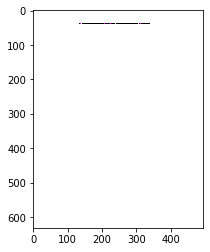

In [127]:
plt.imshow(remove_patch)

In [ ]:

#remove images from background 
if len(img_df > 0) :
    for index , row in img_df.iterrows():
        
    
    

In [129]:
plt.rcParams['figure.figsize'] = [20, 20]

in_df , table_df , line_df = get_text_table_line_df(table_image,df)

NameError: name 'TableRepositories' is not defined

In [ ]:
in_df

In [ ]:
table_df

In [ ]:
table_df['children'][0]

In [ ]:
line_df

In [ ]:
len(table_df)

In [ ]:
table_df['children'][0]

In [ ]:
#extract 


In [ ]:
#delete

In [ ]:
len(df)

In [ ]:
len(ndf)

In [ ]:
tdf['children'][0]

In [ ]:
ndf

# Preprocessing for header, footer page num etc

In [ ]:
preprocess_config = {'header_cut':0.15  , 'footer_cut' :0.15 ,'repeat_threshold' :0.95}

In [ ]:
def cut_page(page_df,height,cut_at,direction):
    
    cut_mark = height * cut_at
    if direction == 'above':
        sub_df = page_df[page_df['text_top'] <= cut_mark ]
        
    else :
        sub_df = page_df[page_df['text_top'] >= cut_mark ]
        
    return sub_df


def add_box_coordinates(sub_df):
    sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
    sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height'] 
    return sub_df

def bb_intersection_over_union(rowA, rowB):
    boxA = [rowA['text_left'] ,rowA['text_top'] , rowA['text_right'] , rowA['text_bottom']]
    boxB = [rowB['text_left'] ,rowB['text_top'] , rowB['text_right'] , rowB['text_bottom']]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA [1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [ ]:

def find_header(xml_dfs ,preprocess_config):
    pdf_levle = []

    page_df   = xml_dfs[0]
    sub_df    = cut_page(page_df,page_height,cut_at=preprocess_config['header_cut'],direction='above')
    sub_df    = add_box_coordinates(sub_df)

    for page2_df in xml_dfs:
        s_df = cut_page(page2_df,page_height,cut_at=preprocess_config['header_cut'],direction='above')
        s_df = add_box_coordinates(s_df)

        page_level = []
        for index1 ,row1 in sub_df.iterrows():   
            iou  = 0
            for index2 , row2 in s_df.iterrows():
                iou += bb_intersection_over_union(row1,row2)

            page_level.append(iou)
        pdf_levle.append(page_level)

    iou_df = pd.DataFrame(pdf_levle,columns=sub_df['text'].values)
    check_repeation =   iou_df.sum() / len(iou_df)
    regions_to_remove = sub_df[list(check_repeation > preprocess_config['repeat_threshold'])]

    
    return regions_to_remove




def find_footer(xml_dfs,preprocess_config):
    pdf_levle = []

    page_df = xml_dfs[0]
    sub_df = cut_page(page_df,page_height,cut_at=preprocess_config['footer_cut'],direction='below')
    sub_df = add_box_coordinates(sub_df)

    for page2_df in xml_dfs:
        s_df     = cut_page(page2_df,page_height,cut_at=preprocess_config['footer_cut'],direction='below')
        s_df = add_box_coordinates(s_df)

        page_level = []
        for index1 ,row1 in sub_df.iterrows():   
            iou  = 0
            for index2 , row2 in s_df.iterrows():
                iou += bb_intersection_over_union(row1,row2)

            page_level.append(iou)
        pdf_levle.append(page_level)

    iou_df = pd.DataFrame(pdf_levle,columns=sub_df['text'].values)
    check_repeation =   iou_df.sum() / len(iou_df)
    regions_to_remove = sub_df[list(check_repeation > preprocess_config['repeat_threshold'])]

    
    return regions_to_remove

In [ ]:
regions_to_remove = find_header(xml_dfs,preprocess_config)

In [ ]:
show_df(regions_to_remove)

In [ ]:
xml_dfs[8].head()

In [ ]:
xml_dfs[9].head()

In [ ]:
header_region = find_header(xml_dfs,preprocess_config)
footer_region = find_footer(xml_dfs,preprocess_config)

In [ ]:
header_region

In [ ]:
footer_region

In [ ]:
#def add_attrib(page_df ,region_to_change,attrib,margin = 5):
page_df = xml_dfs[0]
region_to_change = header_region
margin= 5
attrib ='HEADER'

In [ ]:
def add_attrib(page_df ,region_to_change,attrib,margin = 5):
    if len(region_to_change) > 0 :
        for index, row in region_to_change.iterrows():
            area = [row['text_top'] - margin , row['text_left'] - margin ,row['text_top'] + row['text_height'] + margin , row['text_left']+ row['text_width'] + margin]
            print(area)
            print((page_df['text_top'] >= area[0]) & (page_df['text_left'] >= area[1]) &(page_df['text_top'] + page_df['text_height'] <= area[2]) & (page_df['text_left'] +page_df['text_width'] <= area[3]))
            page_df['attrib'][(page_df['text_top'] >= area[0]) & (page_df['text_left'] >= area[1]) &(page_df['text_top'] + page_df['text_height'] <= area[2]) & (page_df['text_left'] +page_df['text_width'] <= area[3]) ] = attrib
            
    return page_df

In [ ]:
page_df

In [ ]:
# filter page_number based on region and width 

#  1) check widht based on a configurable range, 
#  2) check text in neighbour hood. 


In [ ]:
# Sub script and super script 

#To do :
    # identify if a sub_block contains a sub/super script, so that it can be removed before tokenization
    

# 1) Check if a line has childern
# 2) Check for subscript based on font heights of all children
# 3) remove sub script 
# 4) sub_block  = {'text'   :  ''  ,  'superscript' : []}

In [ ]:
# Foot note 

    # Check if there is a sub script present in page
    # Fire footnote removal 
        #based on line
        #based on font 